In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import mediapy as media
import torch.optim as optim
from einops import rearrange
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
# from model import RecurrentConvNLayer
from model import RecurrentOneLayer

from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
# 1) imports
import json
import torch
from torch.nn import functional as F
from main import LitDenoiser, MNISTDataModule, ImageDataModule  # assumes train_denoiser.py is on your PYTHONPATH
from model import *
import numpy as np
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
def vis_patches(patches, title="", figsize=None, colorbar=False,
                      ncol=None, pad_value="min", show=True,
                      return_tensor=False, vmin=None, vmax=None, fontsize=20,
                      dpi=None, normalize = False):
    """
    Given patches of images in the dataset, create a grid and display it.

    Parameters
    ----------
    patches : Tensor of (batch_size, pixels_per_patch) or 
        (batch_size, channels, pixels_per_patch)

    title : String; title of figure. Optional.
    """
    
    if normalize:
        # print(patches.norm(dim=[-1,-2],keepdim=True).shape)
        patches=patches-patches.mean(dim=(1,2),keepdim=True)
        # patches=patches/patches.norm(dim=[-1,-2],keepdim=True)
        p2p = patches.amax(dim=(1,2),keepdim=True)-patches.amin(dim=(1,2),keepdim=True).clamp(min=1e-8)
        patches=(patches/p2p).clamp(min=-2,max=2)
    
    if patches.dim() == 2:
        channels = 1
        patches.unsqueeze_(1)
    else:
        channels = patches.size(1)
    batch_size = patches.size(0)
    size = int(np.sqrt(patches.size(-1)))

    img_grid = []
    for i in range(batch_size):
        img = torch.reshape(patches[i], (channels, size, size))
        img_grid.append(img)

    if pad_value != 0:
        if pad_value == "min":
            pad_value = torch.min(patches)
        elif pad_value == "max":
            pad_value = torch.max(patches)

    if not ncol:
        ncol = int(np.sqrt(batch_size))
    out = make_grid(img_grid, padding=1, nrow=ncol, pad_value=pad_value)
    # normalize between 0 and 1 for rgb
    if channels == 3:
        out = ((out - torch.min(out))/(torch.max(out) - torch.min(out))).permute(1, 2, 0)
    else:
        out = out[0]

    if show:
        plt.tick_params(axis='both', which='both', bottom=False, left=False,
                        labelbottom=False, labelleft=False)
        plt.xticks([])
        plt.yticks([])
        plt.title(title, fontsize=fontsize)
        fig = plt.gcf()
        ax = plt.gca()
        ax.set_frame_on(False)
        if figsize:
            fig.set_size_inches(figsize)
        if dpi:
            fig.set_dpi(dpi)
        if vmin is not None and vmax is not None:
            if channels != 3:
                plt.imshow(out, cmap="gray", vmin=vmin, vmax=vmax)
            else:
                plt.imshow(out, vmin=vmin, vmax=vmax)
        else:
            if channels != 3:
                plt.imshow(out, cmap="gray")
            else:
                plt.imshow(out)
        if colorbar:
            # this sometimes gets the colorbar to match height of the plot...?
            plt.colorbar(fraction=0.046, pad=0.04)

            # cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
            # cbar = fig.colorbar(cax)
            # cbar.ax.tick_params(labelsize=30) 
        plt.show()
    if return_tensor:
        return out

# ---------- helpers ----------
def _to_display01(x: torch.Tensor) -> np.ndarray:
    """x: [1 or B, C, H, W] in [-1,1] -> numpy image in [0,1]."""
    if x.ndim == 3:
        x = x.unsqueeze(0)
    x = (x + 1.0) * 0.5
    x = x.clamp(0, 1)
    x0 = x[0].detach().cpu()
    if x0.size(0) == 1:      # grayscale
        return x0.squeeze(0).numpy()
    return x0.permute(1, 2, 0).numpy()  # HWC

def _psnr_single(a: torch.Tensor, b: torch.Tensor, peak: float = 2.0) -> float:
    mse = F.mse_loss(a, b, reduction='mean').double().item()
    if mse <= 1e-12:
        return float('inf')
    return 10.0 * np.log10((peak * peak) / mse)

def _crop_numpy(img_np: np.ndarray, y0: int, x0: int, h: int, w: int) -> np.ndarray:
    return img_np[y0:y0+h, x0:x0+w] if img_np.ndim == 2 else img_np[y0:y0+h, x0:x0+w, :]

def _resolve_roi(H, W, roi=None, roi_frac=None):
    """Return integer (y0,x0,h,w) inside image bounds."""
    if roi is not None:
        y0, x0, h, w = map(int, roi)
    else:
        if roi_frac is None:
            roi_frac = (0.35, 0.45, 0.22, 0.22)  # (fy, fx, fh, fw)
        fy, fx, fh, fw = roi_frac
        y0 = int(np.clip(fy * H, 0, H-1))
        x0 = int(np.clip(fx * W, 0, W-1))
        h  = max(1, int(np.clip(fh * H, 1, H)))
        w  = max(1, int(np.clip(fw * W, 1, W)))
    y0 = np.clip(y0, 0, max(0, H-1))
    x0 = np.clip(x0, 0, max(0, W-1))
    h  = min(h, H - y0)
    w  = min(w, W - x0)
    return int(y0), int(x0), int(h), int(w)

# ---------- main: 5-panel with zoom ----------
@torch.inference_mode()
def show_denoising_with_zoom_three(
    y, net1, net2, net3, sigma_viz, peak, *,
    name_1="Net1", name_2="Net2", name_3="Net3",
    idx_img=None, idx_sigma=None,
    aug_labels=None,
    roi=None, roi_frac=None,
    inset_size=0.45,                 # fraction of axes size (0..1)
    inset_loc="upper right",
    zoom_border_color="yellow",
    seed=None,
    device = 'cuda',
    save_path = "./figures"
):
    """
    y: clean batch [B,C,H,W] in [-1,1]
    sigma_viz: scalar or 1D tensor of sigmas
    peak: dynamic range (2.0 for [-1,1])
    """
    B, C, H, W = y.shape

    # choose sample/sigma
    if idx_img is None:
        idx_img = np.random.randint(B)
    sigma_viz_cpu = torch.as_tensor(sigma_viz).detach().cpu()
    if sigma_viz_cpu.ndim == 0:
        idx_sigma = 0
        s_sel = float(sigma_viz_cpu.item())
        noisy_psnr = float(10.0 * torch.log10(peak**2 / (sigma_viz_cpu**2)).item())
    else:
        if idx_sigma is None:
            idx_sigma = np.random.randint(len(sigma_viz_cpu))
        s_sel = float(sigma_viz_cpu[idx_sigma].item())
        noisy_psnr = float(10.0 * torch.log10(peak**2 / (sigma_viz_cpu[idx_sigma]**2)).item())
    # print(y.shape)
    clean = y[idx_img:idx_img+1].to(device)
    sb1   = torch.tensor(s_sel, device=clean.device, dtype=clean.dtype).view(1,1,1,1)

    # make noisy
    if seed is not None:
        # g = torch.Generator(device=clean.device).manual_seed(int(seed))
        noisy_1img = clean + torch.randn_like(clean) * sb1
    else:
        noisy_1img = clean + torch.randn_like(clean) * sb1

    # run all three nets once
    # print(noisy_1img.shape,sb1.shape,aug_labels)
    out1 = net1(noisy_1img, noise_labels = sb1.flatten())
    out2 = net2(noisy_1img, noise_labels = sb1.flatten())
    out3 = net3(noisy_1img, noise_labels = sb1.flatten())

    # PSNRs
    psnr_noisy = noisy_psnr
    psnr_out1  = _psnr_single(out1, clean, peak=float(peak))
    psnr_out2  = _psnr_single(out2, clean, peak=float(peak))
    psnr_out3  = _psnr_single(out3, clean, peak=float(peak))

    # convert to display
    img_clean = _to_display01(clean)
    img_noisy = _to_display01(noisy_1img)
    img_out1  = _to_display01(out1)
    img_out2  = _to_display01(out2)
    img_out3  = _to_display01(out3)

    # ROI and crops
    y0, x0, h, w = _resolve_roi(H, W, roi=roi, roi_frac=roi_frac)
    crops = [
        _crop_numpy(img_clean, y0, x0, h, w),
        _crop_numpy(img_noisy, y0, x0, h, w),
        _crop_numpy(img_out1, y0, x0, h, w),
        _crop_numpy(img_out2, y0, x0, h, w),
        _crop_numpy(img_out3, y0, x0, h, w),
    ]

    titles = [
        "Clean — PSNR=∞",
        f"Noisy — PSNR={psnr_noisy:.2f} dB",
        f"{name_1} — PSNR={psnr_out1:.2f} dB",
        f"{name_2} — PSNR={psnr_out2:.2f} dB",
        f"{name_3} — PSNR={psnr_out3:.2f} dB",
    ]
    images = [img_clean, img_noisy, img_out1, img_out2, img_out3]

    # Plot 1×5
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for ax, im, crop, title in zip(axes, images, crops, titles):
        if im.ndim == 2:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(im)
        ax.set_title(title, fontsize=10)
        ax.axis('off')

        # ROI rect
        rect = Rectangle((x0, y0), w, h, linewidth=2, edgecolor=zoom_border_color, facecolor='none')
        ax.add_patch(rect)

        # inset
        axins = inset_axes(ax, width=f"{int(inset_size*100)}%", height=f"{int(inset_size*100)}%", loc=inset_loc)
        if crop.ndim == 2:
            axins.imshow(crop, cmap='gray')
        else:
            axins.imshow(crop)
        axins.set_xticks([]); axins.set_yticks([])
        for spine in axins.spines.values():
            spine.set_edgecolor(zoom_border_color)
            spine.set_linewidth(2)
            
    # --- Save before show ---
    if save_path is not None:
        save_dir = os.path.dirname(str(save_path))
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
        fig.savefig(str(save_path), dpi=200, bbox_inches='tight', pad_inches=0.02)

    plt.tight_layout()
    plt.show()


import numpy as np
import mediapy as media

def _pad_center(video: np.ndarray, H: int, W: int, fill: float = 1.0) -> np.ndarray:
    """Pad (T,h,w) to (T,H,W) with 'fill' (white=1.0), centered."""
    T, h, w = video.shape
    if h == H and w == W:
        return video
    out = np.full((T, H, W), fill, dtype=np.float32)
    top  = (H - h) // 2
    left = (W - w) // 2
    out[:, top:top+h, left:left+w] = video
    return out

def make_side_by_side_white_many(videos, gap_px: int = 16, fill: float = 1.0):
    """
    videos: list of (T,H,W) grayscale arrays (float [-1,1] or [0,1], or uint8)
    Returns: (T, Hmax, sum_width) stitched video with white padding and white gaps.
    """
    assert isinstance(videos, (list, tuple)) and len(videos) > 0, "Provide a non-empty list of videos."

    vids = [v for v in videos ]
    # sync time
    T = min(v.shape[0] for v in vids)
    vids = [ v[:T] for v in vids ]

    # pad every clip to a common (Hmax, Wmax)
    Hmax = max(v.shape[1] for v in vids)
    Wmax = max(v.shape[2] for v in vids)
    vids = [ _pad_center(v, Hmax, Wmax, fill=fill) for v in vids ]

    # white gap
    gap = np.full((T, Hmax, gap_px), fill, dtype=np.float32) if len(vids) > 1 else None

    # interleave videos with gaps
    pieces = []
    for i, v in enumerate(vids):
        pieces.append(v)
        if gap is not None and i < len(vids) - 1:
            pieces.append(gap)

    combo = np.concatenate(pieces, axis=2)  # (T, Hmax, N*Wmax + (N-1)*gap_px)
    return combo

2025-11-05 18:11:55.424358: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# !pip install "protobuf==5.28.3"

In [4]:
def load_net(BASE_DIR):

    # 3) load the config
    with open(f"{BASE_DIR}/config.json", "r") as f:
        config = json.load(f)
    # print(config)
    # 4) rebuild the model (Lightning will wrap it, but we just need the raw module here)
    clean_config_dict  = {
        k: config[k] for k in [
            "in_channels", "num_basis", "eta_base", "n_iters_inter", "n_iters_intra",
            "kernel_size", "stride",
            "sigma","lr",
            "ema_halflife_kimg","ema_rampup_ratio",
            "model_arch", "eta_ls", 
            "P_mean","P_std", "edm_weighting",
            "jfb_no_grad_iters","jfb_with_grad_iters","jfb_reuse_solution","jfb_ddp_safe",
            "whiten_dim","T"
        ]
    }
    clean_config_dict["learning_horizontal"] = not config["no_learning_horizontal"]
    clean_config_dict["stable"] = config.get("stable")
    # clean_config_dict  = {
    #     k: config[k] for k in [
    #         "in_channels", "num_basis", "eta_base", "n_iters_inter", "n_iters_intra",
    #         "kernel_size", "stride",
    #         "sigma","lr",
    #         "ema_halflife_kimg","ema_rampup_ratio",
    #         "model_arch",
    #         "P_mean","P_std", "edm_weighting",
    #     ]
    # }
    model = LitDenoiser(**clean_config_dict)
    model.eval()  # important!
    model = model.to(device)

    # 5) load the checkpoint
    #    if you used save_weights_only=True you need to wrap it in state_dict
    ckpt_path = f"{BASE_DIR}/{config.get('best_ckpt', 'denoiser.ckpt')}"
    state = torch.load(ckpt_path, map_location="cpu")
    if "state_dict" in state:
        model.load_state_dict(state["state_dict"])
    else:
        model.load_state_dict(state)

    return config,model

In [5]:
# cp -r pretrained_model/scaling-VH-new/00088_layer1-SC-whiten-1-noise-labels-zero-scratch-horizontal-weighting-straighten-from-reuse model_banks
# rm -rf model_banks/00088_layer1-SC-whiten-1-noise-labels-zero-scratch-horizontal-weighting-straighten-from-reuse/wandb
# mv model_banks/00088_layer1-SC-whiten-1-noise-labels-zero-scratch-horizontal-weighting-straighten-from-reuse HC_model

In [200]:
device = "cuda:0"
# no weighting
# BASE_DIR1 = f"./pretrained_model/scaling-VH-new/00033_layer1-SC-whiten-noise-labels"
# BASE_DIR2 = f"./pretrained_model/scaling-VH-new/00056_layer1-SC-whiten-noise-labels-zero-scratch-horizontal"

# with weighting
# BASE_DIR3 = "pretrained_model/00088_layer1-SC-whiten-1-noise-labels-zero-scratch-horizontal-weighting-straighten-from-reuse"
# BASE_DIR3 = "model_banks/HC_model"
BASE_DIR3 = "pretrained_model/scaling-VH-new-2/00038_layer1-SC-noise-labels-zero-scratch-reuse-horizontal"
config,net3 = load_net(BASE_DIR3)
net_infer = net3
# 6) prepare the data
# dm = ImageDataModule(batch_size=config["batch_size"],data_dir = "/home/zeyu/celeba")
# dm = ImageDataModule(batch_size=config["batch_size"],data_dir = "/home/zeyu/vanhateren_all/vh_patches256_train")
dm = ImageDataModule(
    data_dir=config["data_dir"],
    # data_dir="/home/zeyu/data/celeba",
    batch_size=32,
    num_workers=4,
    # img_size=config["img_size"],
    img_size = 256,
    val_split=0.2,
    test_split=0.0,
    seed=42,
    grayscale=config["grayscale"],
    no_resize=config["no_resize"],
    random_crop=config["random_crop"],
)
dm.setup()  # runs prepare_data + splits
test_loader = dm.test_dataloader()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

# avg_snr = evaluate_snr(model, test_loader,device,sigma =sigma)

<class 'model.RecurrentOneLayer_reuse'>
EMA <class 'model.RecurrentOneLayer_reuse'>


/tmp/ipykernel_702142/830820413.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")


In [201]:
# MAX_IMAGES= 100
counter = 0 
imgs_ls = []
for imgs, _ in tqdm(val_loader):
    imgs_ls.append(imgs)
    counter+=1
    # break
imgs_ls = torch.cat(imgs_ls)

100%|█████████████████████████████████████████| 155/155 [00:02<00:00, 60.75it/s]


In [8]:
def decoded_hist_convert(model,hist):
    with torch.no_grad():
        return [model.decoder(d[0].to(device)).cpu() for d in hist]

## Visualizing dynamics

In [83]:
sigma_viz = 0.2
B=8
sb1 = torch.ones(B).to(device)*sigma_viz

In [84]:
# write a function to calculate statitics only?

In [85]:
# net_infer.model.eta_base = 0.1

In [256]:

a =None
decoded=None
decoded_hist = {"a":[],"decoded":[],"clean":[],"noisy":[]}
other_hist = {}
# You can pick how many image you want to visualize, and how many iteration you run, making n_iter too high will cause explosion
n_iter = 10
for i in range(1):
    clean_1 = imgs_ls[torch.randperm(len(imgs_ls))[:B]].to(device)
    noisy_1img = clean_1 + torch.randn_like(clean_1) * sb1.view(B,1,1,1)
    a, decoded, decoded_hist_new= net_infer.model.infer(noisy_1img,a=a,decoded=decoded,noise_labels = sb1,n_iter = n_iter,return_feature=True,return_hist = True)
    # decoded_hist["a"].extend(decoded_hist_new["a"] + [decoded_hist_new["a"][-1]])
    # decoded_hist["decoded"].extend([noisy_1img.cpu()]+decoded_hist_convert(net_infer.model,decoded_hist_new['decoded']))
    # decoded_hist["clean"].extend([clean_1]*(n_iter+1))
    # decoded_hist["noisy"].extend([noisy_1img]*(n_iter+1))
    decoded_hist["a"].extend(decoded_hist_new["a"])
    decoded_hist["decoded"].extend(decoded_hist_convert(net_infer.model,decoded_hist_new['decoded']))
    decoded_hist["clean"].extend([clean_1]*(n_iter))
    decoded_hist["noisy"].extend([noisy_1img]*(n_iter))

In [257]:
#     Ca =  -self.levels[i].gram_vector_product(a_det) + self.levels[i].M(a_det)
# aCa = (a_det * Ca).sum(dim=[1, 2, 3]).mean().item()

In [258]:
# decoded_hist_viz = decoded_hist_convert(net_infer.model,decoded_hist['decoded'])
decoded_hist_viz = decoded_hist["decoded"]
decoded_hist_viz_cat = torch.stack(decoded_hist_viz)

a_hist =  torch.stack([a[0] for a in decoded_hist["a"]]).cpu()
noisy_hist =  torch.stack(decoded_hist["noisy"]).cpu()
clean_hist = torch.stack(decoded_hist["clean"]).cpu()

recon_loss = ((decoded_hist_viz_cat - noisy_hist)**2).flatten(2).sum(dim=-1)
denoise_loss = ((decoded_hist_viz_cat - clean_hist)**2).flatten(2).sum(dim=-1)
nonzero_hist = (a_hist>0).float().mean(dim= [-1,-2,-3])

aMa_hist = []
with torch.no_grad():
    for a_ in a_hist:
        Ma = net_infer.model.levels[0].M(a_.to(device))
        aMa = (a_.to(device)*Ma).sum(dim=[1, 2, 3])
        aMa_hist.append(aMa.cpu())
aMa_hist = torch.stack(aMa_hist)

In [259]:
# plt.plot(nonzero_hist.mean(1))

In [260]:
# energy feature map

In [261]:
# recon_loss_spatial = ((decoded_hist_viz_cat - noisy_hist)**2).flatten(2).sum(dim=-1)
# denoise_loss_spatial = ((decoded_hist_viz_cat - clean_hist)**2).flatten(2).sum(dim=-1)
# nonzero_hist_spatial = (a_hist>0).float().mean(dim= [-1,-2,-3])

In [262]:
# (a_hist>0)[-1,0,:,10,0]

In [263]:
nonzero_hist_spatial = (a_hist>0).float().mean(dim=2)
aMa_hist_spatial = []
with torch.no_grad():
    for a_ in a_hist:
        Ma = net_infer.model.levels[0].M(a_.to(device))
        aMa = (a_.to(device)*Ma).sum(dim=[1])
        aMa_hist_spatial.append(aMa.cpu())
aMa_hist_spatial = torch.stack(aMa_hist_spatial)

In [266]:
# net_infer.model.levels

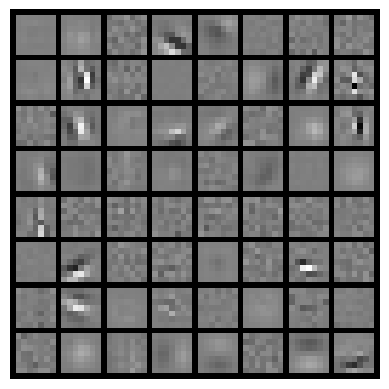

In [267]:
# Visualize kernels and horizontal connections
w2 = net_infer.model.levels[0].decoder.conv.weight.detach()
if net_infer.hparams.whiten_dim is not None:
    with torch.no_grad():
        w2 = net_infer.model.decoder(w2).cpu()
vis_patches(w2.flatten(2).cpu(),normalize=False)

In [268]:
# net_infer.model.levels[0].encoder.weight

In [269]:
# net_infer.model.levels[0].encoder.weight

In [270]:
net_infer.model.levels[0]._enc_wn.reset(net_infer.model.levels[0].encoder)

In [271]:
net_infer.model.levels[0].encoder.weight.flatten(1).norm(dim=1).shape

torch.Size([64])

In [272]:
# net_infer.model.levels[0].encoder.weight_g

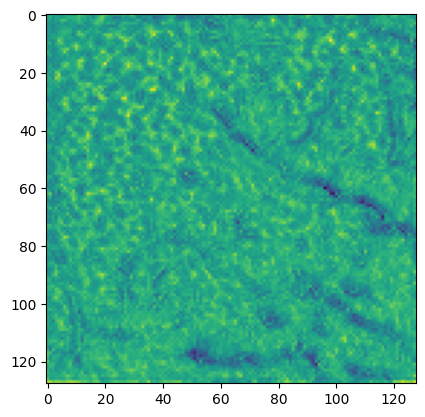

In [286]:
plt.imshow(aMa_hist_spatial[-1,7])

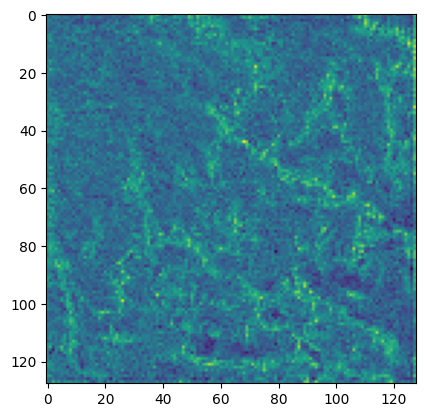

In [285]:
plt.imshow(nonzero_hist_spatial[-1,7])

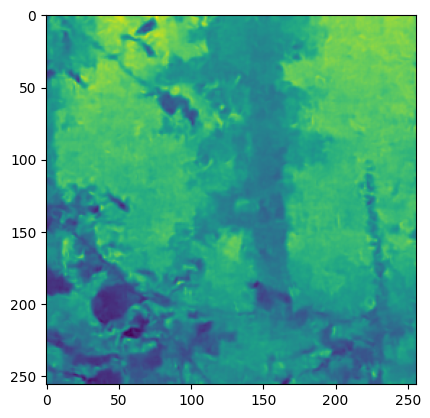

In [277]:
plt.imshow(decoded_hist["decoded"][-1][4,0].cpu())


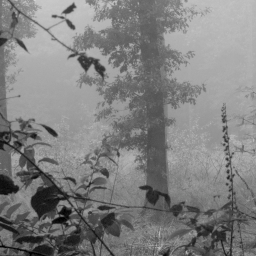
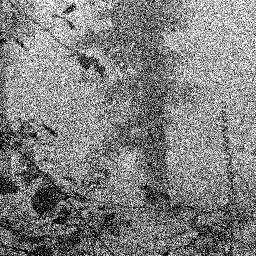
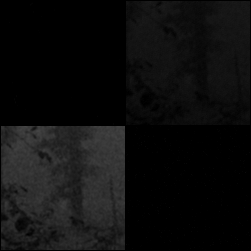
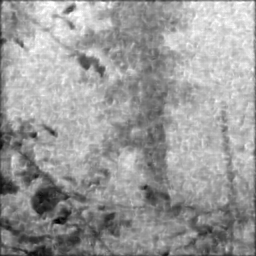

In [278]:
idx=4
b_width = 2
a_idx_viz_ls = [13,18,31,32]
a_hist_viz = a_hist[:,idx,a_idx_viz_ls]
a_hist_viz = a_hist_viz[:,:,b_width:-b_width,b_width:-b_width]
a_hist_viz = torch.stack([vis_patches(a_viz.flatten(1),return_tensor=True,show=False) for a_viz in a_hist_viz])
# video_ls = [noisy_hist[:,idx,0].numpy(), decoded_hist_viz_cat[:,idx,0].numpy(), a_hist_viz.numpy()]
video_ls = [clean_hist[:,idx,0].numpy(),  noisy_hist[:,idx,0].numpy(), a_hist_viz.numpy(), decoded_hist_viz_cat[:,idx,0].numpy()]
media.show_videos(video_ls,codec = "gif",fps =10,width = 300)

In [279]:
# combo = make_side_by_side_white_many(video_ls, gap_px=64, fill=1.0)
# media.write_video("figures/n_way_whitegap_high_more.gif", combo, fps=10, codec="gif")
# # media.show_video(combo, fps=10, codec="gif", width=900)  # optional inline preview

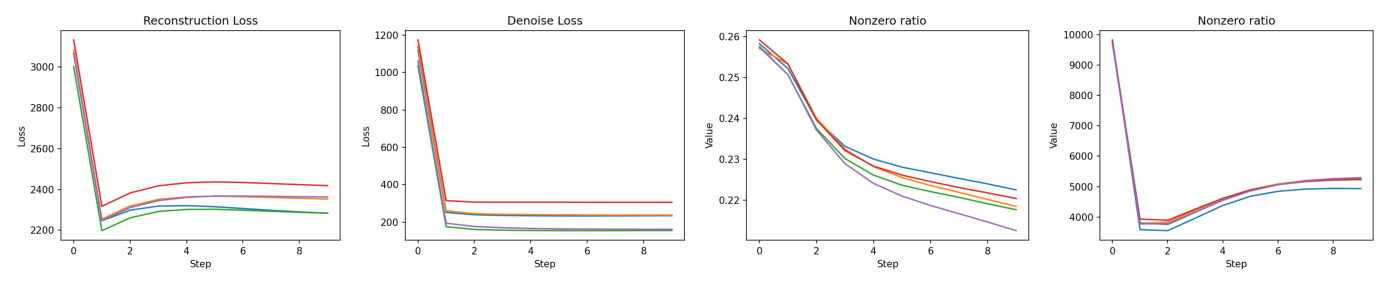

In [280]:
# Simpler: make three separate figures, save each to an in-memory PNG, then stitch them side by side.
# No use of canvas.tostring_rgb. Replace `recon_loss`, `denoise_loss`, `nonzero_hist`
# with your real arrays/tensors and re-run.

import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

try:
    import torch
    _HAS_TORCH = True
except Exception:
    _HAS_TORCH = False

def to_np_2d(x):
    if _HAS_TORCH and isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    else:
        x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, None]
    elif x.ndim > 2:
        x = x.reshape(x.shape[0], -1)
    return x

def plot_panel_to_image(data_2d, title, xlabel="Step", ylabel="Value", figsize=(5,4), N = 5):
    fig = plt.figure(figsize=figsize)
    T, _ = data_2d.shape
    for j in range(N):
        plt.plot(data_2d[:, j])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", dpi=150)
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf).convert("RGB")

def hstack(pil_images, pad=12, pad_color=(255,255,255)):
    # Normalize to same height
    h = max(im.height for im in pil_images)
    resized = []
    for im in pil_images:
        if im.height != h:
            w = int(im.width * (h / im.height))
            im = im.resize((w, h), Image.BICUBIC)
        resized.append(im)
    total_w = sum(im.width for im in resized) + pad * (len(resized) - 1)
    canvas = Image.new("RGB", (total_w, h), pad_color)
    x = 0
    for k, im in enumerate(resized):
        canvas.paste(im, (x, 0))
        x += im.width
        if k < len(resized) - 1:
            x += pad
    return canvas

# --- Use provided arrays if available; else create tiny demo so you see layout ---
N = 5 
recon_np = to_np_2d(recon_loss)
denoise_np = to_np_2d(denoise_loss)
nonzero_np = to_np_2d(nonzero_hist)
aMa_np = to_np_2d(aMa_hist)

img1 = plot_panel_to_image(recon_np,   "Reconstruction Loss", "Step", "Loss",N=N)
img2 = plot_panel_to_image(denoise_np, "Denoise Loss",        "Step", "Loss",N=N)
img3 = plot_panel_to_image(nonzero_np, "Nonzero ratio",   "Step", "Value",N=N)
img4 = plot_panel_to_image(aMa_np, "Nonzero ratio",   "Step", "Value",N=N)

combo = hstack([img1, img2, img3, img4], pad=16)

# Show + save
plt.figure(figsize=(14,4))
plt.imshow(combo)
plt.axis("off")
plt.tight_layout()

In [281]:
# recon_loss.shape

In [283]:
# [1:]

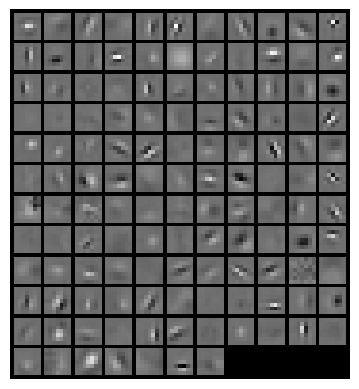

In [54]:
# Visualize kernels and horizontal connections
w2 = net_infer.model.levels[0].decoder.conv.weight.detach()
if net_infer.hparams.whiten_dim is not None:
    with torch.no_grad():
        w2 = net_infer.model.decoder(w2).cpu()
vis_patches(w2.flatten(2),normalize=False)

In [279]:
# # get ride of weird ones ?
# get_rid_off = [8,11,21,22,23,25,29,38,31,32,42,45,50,57,60,61,62,65,68,70,71,72,73,75,77,78,79,86,87,88,89,99,97,93,101,75]
# all_idx = set(range(128))
# remaining = sorted(all_idx - set(get_rid_off))
# vis_patches(w2[remaining].flatten(2),normalize=True)

In [292]:
# equal_contrast
def equal_contrast(patches,th = 2):
    patches=patches-patches.mean(dim=(1,2),keepdim=True)
    # patches=patches/patches.norm(dim=[-1,-2],keepdim=True)
    p2p = patches.amax(dim=(1,2),keepdim=True)-patches.amin(dim=(1,2),keepdim=True).clamp(min=1e-8)
    patches=(patches/p2p).clamp(min=-th,max=th)
    return patches

In [293]:
# pad and attempt to make needle plot
import torch

def _avg_pad_to_11(w2: torch.Tensor) -> torch.Tensor:
    """
    w2: (B, 1, 7, 7) -> (B, 1, 11, 11) with per-kernel average padding.
    """
    B, C, H, W = w2.shape
    assert (C, H, W) == (1, 7, 7)
    mean = w2.mean(dim=(-1, -2), keepdim=True)          # (B,1,1,1)
    out = mean.expand(B, 1, 11, 11).clone()              # fill with mean
    out[:, :, 2:-2, 2:-2] = w2                           # center insert
    return out

def _shift_fill(x: torch.Tensor, dy: int, dx: int, fill11: torch.Tensor) -> torch.Tensor:
    """
    Shift x by (dy, dx) inside 11x11 canvas; new areas filled with per-kernel mean.
    x:      (B,1,11,11)
    fill11: (B,1,11,11) filled with each kernel's mean value
    """
    B, C, H, W = x.shape
    out = fill11.clone()
    y0, y1 = max(0, dy), H + min(0, dy)
    x0, x1 = max(0, dx), W + min(0, dx)
    out[:, :, y0:y1, x0:x1] = x[:, :, y0 - dy:y1 - dy, x0 - dx:x1 - dx]
    return out

def pad_and_make_9_shifts(w2: torch.Tensor, shift: int = 2) -> torch.Tensor:
    """
    w2: (B,1,7,7) -> (B,9,1,11,11)
    Order of the 9 is row-major over (dy,dx) in [-shift,0,shift]:
    [(-s,-s), (-s,0), (-s,+s), (0,-s), (0,0), (0,+s), (+s,-s), (+s,0), (+s,+s)]
    """
    base11 = _avg_pad_to_11(w2)                          # (B,1,11,11)
    mean = w2.mean(dim=(-1, -2), keepdim=True)           # (B,1,1,1)
    fill11 = mean.expand_as(base11)                      # (B,1,11,11)

    shifts = [(-shift, -shift), (-shift, 0), (-shift, +shift),
              (0, -shift),      (0, 0),      (0, +shift),
              (+shift, -shift), (+shift, 0), (+shift, +shift)]
    variants = [_shift_fill(base11, dy, dx, fill11) for dy, dx in shifts]
    return torch.stack(variants, dim=1)                  # (B,9,1,11,11)

In [294]:
b,c,h,w=w2.shape
w2_viz = equal_contrast(w2.flatten(2),th=3).view(b,c,h,w)

# w2_padded = _avg_pad_to_11(w2)
w2_aug = pad_and_make_9_shifts(w2_viz)
b1,b2,c,h,w=w2_aug.shape

In [295]:
w2_aug_viz = w2_aug.flatten(0,1).flatten(2)
w2_aug_viz = w2_aug_viz/w2_aug_viz.norm(dim=-1,keepdim=True)
w2_aug_viz = rearrange(w2_aug_viz,"(b1 b2) c (h w) -> b1 b2 c h w ",b1 = b1,h=h)

In [296]:
# vis_patches(w2_aug[:,0].flatten(1))

In [303]:
gabor_dict = {}
recon_gabor = np.zeros(w2_aug_viz.shape)
for i in range(w2_aug_viz.shape[0]):
    for j in range(w2_aug_viz.shape[1]):
        gabor_dict[(i,j)] = fit(w2_aug_viz[i][j][0].numpy(),allowed_retries=10)
        recon_gabor[i,j,0] = gabor_dict[(i,j)]['reconstruction']
        # break
    # break

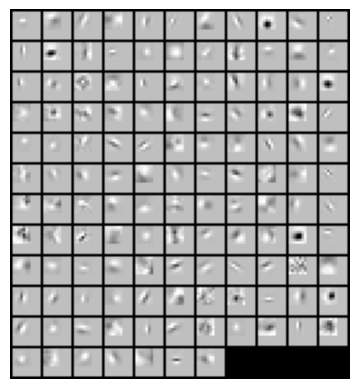

In [304]:
vis_patches(w2_aug[:,0].flatten(1))

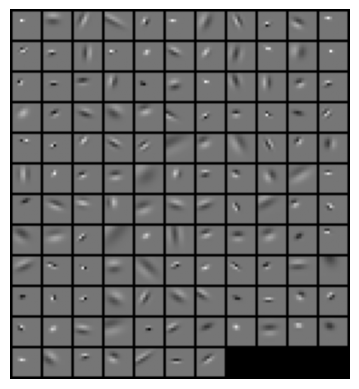

In [305]:
vis_patches(torch.tensor(recon_gabor[:,0,0]).flatten(1))

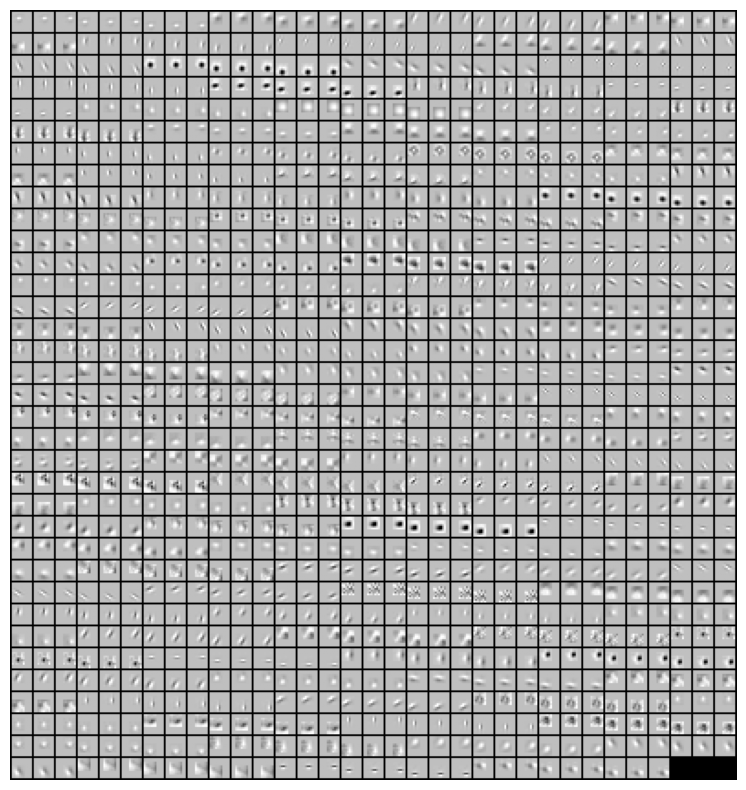

In [306]:
vis_patches(w2_aug.flatten(end_dim=1).flatten(1),figsize = (10,10))

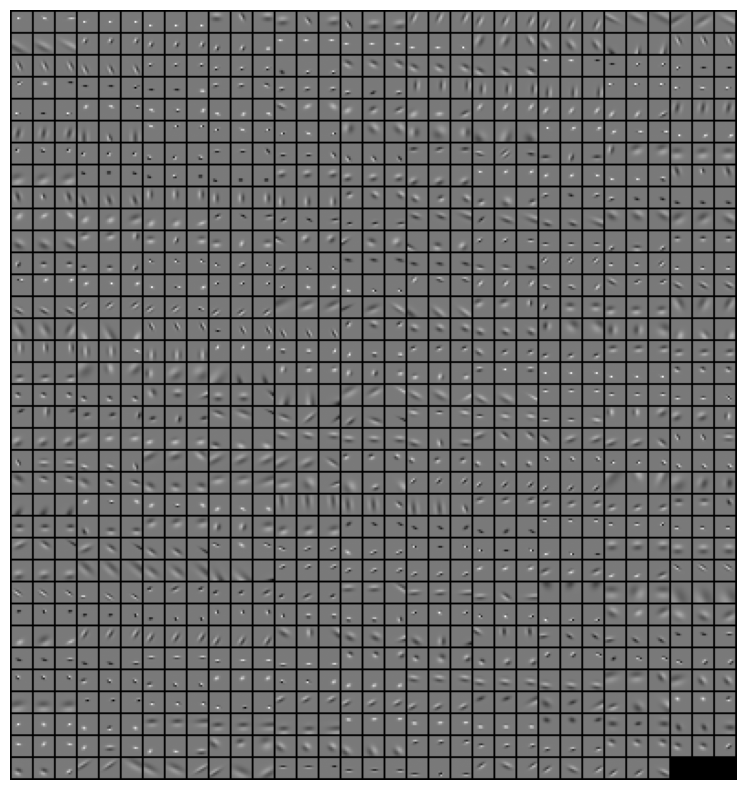

In [308]:
vis_patches(torch.tensor(recon_gabor[:]).flatten(end_dim=1).flatten(1),figsize = (10,10))

In [313]:
fitted_gabors_dict = gabor_dict

In [317]:
width_ls = np.array([fitted_gabors_dict[gabor_idx]['parameters']['envelope_width'] for gabor_idx in fitted_gabors_dict])

In [318]:
length_min = width_ls.min()
def get_ln(dim,wid = False,ss_neuron=True):
    theta = fitted_gabors_dict[dim]['parameters']['orientation']
    length = (fitted_gabors_dict[dim]['parameters']['envelope_width']-length_min)/2
    if ss_neuron:
        length = length*2
    l_width = 20*fitted_gabors_dict[dim]['parameters']['envelope_aspect']
    x,y= fitted_gabors_dict[dim]['parameters']['position_yx']
#     y=-y

    x_length = length*np.cos(theta)
    y_length = length*np.sin(theta)
    x_start = x - 0.5*x_length/2
    y_start = y - 0.5*y_length/2
    x_end = x + 0.5*x_length/2
    y_end = y + 0.5*y_length/2
    lines = [[(x_start,y_start),(x_end,y_end)],]
    return lines

In [363]:
# plt.plot
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
    
x = np.array([fitted_gabors_dict[gabor_idx]['parameters']['position_yx'][0] for gabor_idx in fitted_gabors_dict])
y = np.array([fitted_gabors_dict[gabor_idx]['parameters']['position_yx'][1] for gabor_idx in fitted_gabors_dict])

rho = np.array([fitted_gabors_dict[gabor_idx]['parameters']['frequency'] for gabor_idx in fitted_gabors_dict])
phi = np.array([fitted_gabors_dict[gabor_idx]['parameters']['orientation'] for gabor_idx in fitted_gabors_dict])
x_2,y_2 = pol2cart(rho,phi)
x_2_,y_2_ = pol2cart(rho,phi+np.pi)
x_2 = np.concatenate((x_2,x_2_))
y_2 = np.concatenate((y_2,y_2_))

In [364]:
k2 = net_infer.model.levels[0].M.weight.data.clone()
M_steer = k2.flatten(1)
U, S, Vh = torch.linalg.svd(M_steer, full_matrices=False)

In [379]:
eigen_vis = Vh.cpu().numpy()
from scipy import stats
def remove_outlier(x):
    x[(np.abs(stats.zscore(x)) > 3)] = 0
    return x

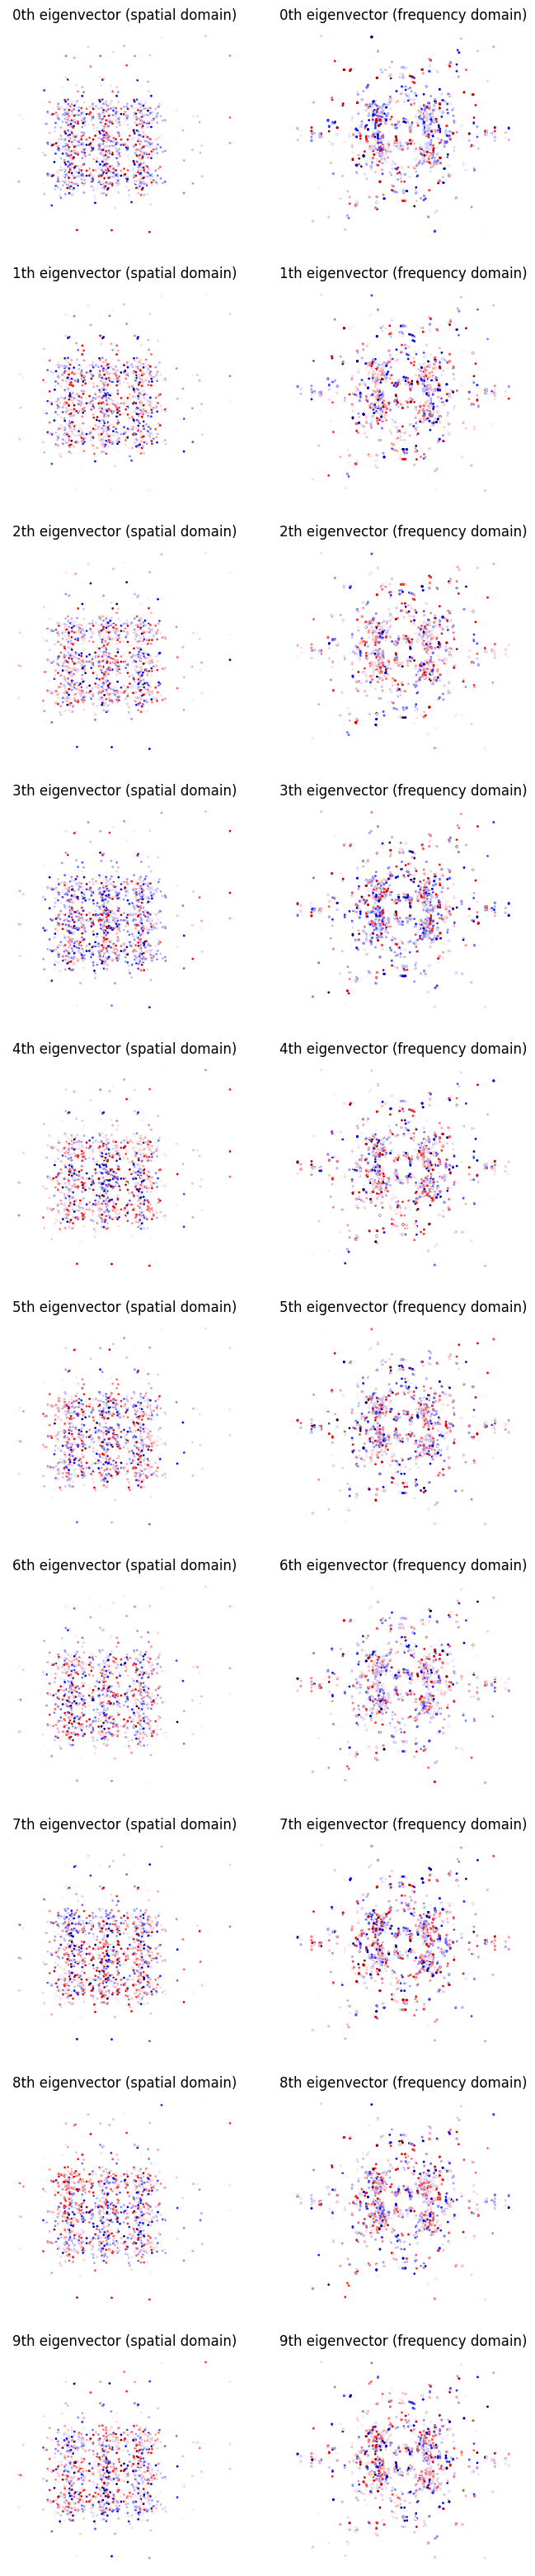

In [382]:
needle=False
# k_range = list(range(start_dim,end_dim))
start_dim=0
end_dim = 10
k_range = range(start_dim,end_dim)
num_rows = len(k_range)

if needle:
    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
else:
    fig, axes = plt.subplots(num_rows, 2, figsize=(8, 4 * num_rows))
    
for k in k_range:
    eigen_vis_k = remove_outlier(eigen_vis[k])
    if needle:
        axes[k,-1].set_xlim([-show_lim_2,show_lim_2])
        axes[k,-1].set_ylim([-show_lim_2,show_lim_2])
        axes[k,-1].axis('off')
        axes[k,-1].set_title("{}th eigenvector (needle short)".format(k))
        # for j,i in enumerate(scale2_idx):
        for key in fitted_gabors_dict.keys():
            lines = get_ln(key)
            lc = mc.LineCollection(lines, inewidths=1)
            axes[k,-1].add_collection(lc)

    axes[k,0].axis('off')
    axes[k,0].set_title("{}th eigenvector (spatial domain)".format(k))
    axes[k,0].scatter(x,y,c = eigen_vis_k,s=1,cmap = "seismic")
    axes[k,1].axis('off')
    axes[k,1].set_title("{}th eigenvector (frequency domain)".format(k))
    axes[k,1].scatter(x_2,y_2,c = eigen_vis_k.repeat(2),s=1,cmap = "seismic")